# Define model validation metrics

In [1]:
import os
import h5py
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from toolz import valmap
from tqdm.auto import tqdm
from aging.size_norm.lightning import predict
# below is necessary for now, might not need in future iterations
from aging.size_norm.data import clean, Session
from toolz import keyfilter

from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, cross_val_predict
from sklearn.metrics import r2_score
from aging.plotting import format_plots, PlotConfig, save_factory
from sklearn.metrics import confusion_matrix

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "network-optim", tight_layout=False)

## Apply model to validation data

In [3]:
if not torch.cuda.is_available():
    torch.set_num_threads(int(os.environ.get("SLURM_CPUS_PER_TASK", 1)))

In [4]:
mdl_path = '/n/groups/datta/win/longtogeny/size_norm/models/pre_final_model/model.pt'
mdl = torch.jit.load(mdl_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
max_frames = 12_500

data = {}
preds = {}

val_data_path = Path(
    "/n/groups/datta/win/longtogeny/data/size_network/male_ontogeny_validation.h5"
)
with h5py.File(val_data_path, "r") as h5f, torch.no_grad():
    for key in tqdm(list(filter(lambda x: '22month' not in x, h5f["data"]))):
        data[key] = h5f["data"][key][:max_frames]
        preds[key] = predict(Session(data[key]), mdl)

preds = valmap(lambda v: np.where(v < 1, 0, v), preds)
data = valmap(lambda v: np.array(list(map(clean, v))), data)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
list(preds)

['session_20210419130121_3months_19042021',
 'session_20210419135601_3months_19042021',
 'session_20210420124510_6months_20042021',
 'session_20210421132959_6months_20042021',
 'session_20210428134015_12months_28042021',
 'session_20210428142014_12months_28042021',
 'session_20210429122136_18months_29042021',
 'session_20210429130503_18months_29042021',
 'session_20211029123208_5wks_02112021',
 'session_20211118115344_7wks_18112021',
 'session_20211118143846_7wks_18112021',
 'session_20230605130947_3wks_02112021',
 'session_20230605131002_3wks_02112021',
 'session_20230605134839_5wks_02112021',
 'session_20230605151759_9wks_1811_2021',
 'session_20230605151811_9wks_1811_2021',
 'session_20230609113832_9months_060923',
 'session_20230609130044_9months_060923']

In [7]:
vvals = dict(vmin=0, vmax=45)

session_20230605131002_3wks_02112021


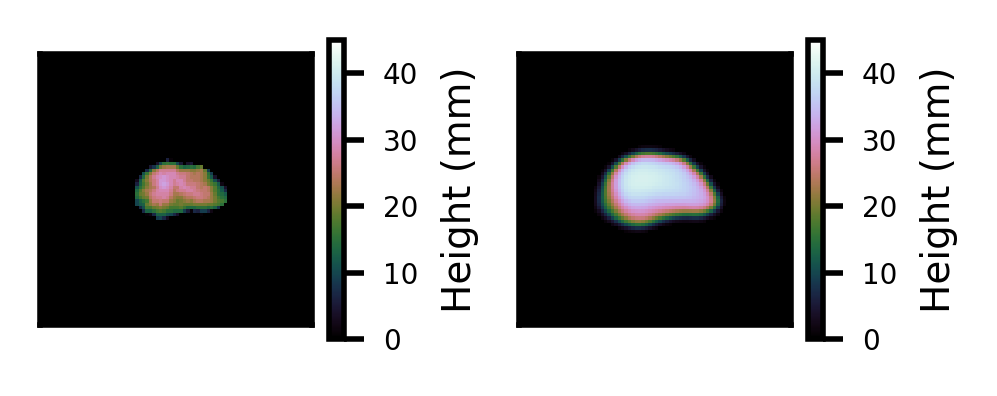

In [8]:
cmap = 'cubehelix'
_key = list(preds)[-6]
print(_key)
idx = 150
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1))
im = ax[0].imshow(data[_key][idx], cmap=cmap, **vvals)
fig.colorbar(mappable=im, ax=ax[0], label='Height (mm)')
im = ax[1].imshow(preds[_key][idx], cmap=cmap, **vvals)
fig.colorbar(mappable=im, ax=ax[1], label='Height (mm)')
for a in ax.flat:
    a.set(xticks=[], yticks=[])
saver(fig, 'small-mouse-recon-example', tight_layout=True);

session_20210429122136_18months_29042021


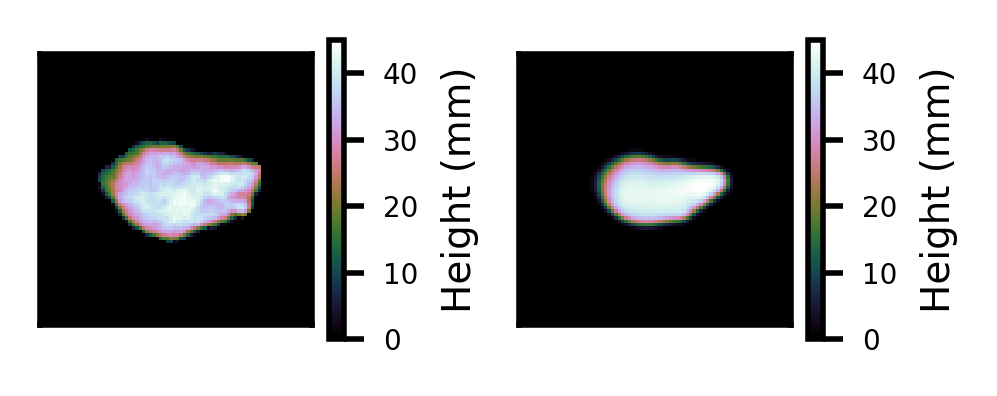

In [9]:
cmap = 'cubehelix'
_key = list(preds)[6]
print(_key)
idx = 1070
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1))
im = ax[0].imshow(data[_key][idx], cmap=cmap, **vvals)
fig.colorbar(mappable=im, ax=ax[0], label='Height (mm)')
im = ax[1].imshow(preds[_key][idx], cmap=cmap, **vvals)
fig.colorbar(mappable=im, ax=ax[1], label='Height (mm)')
for a in ax.flat:
    a.set(xticks=[], yticks=[])
saver(fig, 'large-mouse-recon-example', tight_layout=True);

## Mouse age classification

Classify age before and after applying model.
Start with logistic regression or random forest classifier.

### Select similar poses within each group

In [10]:
pipeline = make_pipeline(
    PCA(n_components=10),
    StandardScaler(),
)

n_clusters = 25

min_lbl_count = []

lbls = {}

for k, v in tqdm(preds.items()):
    _data = pipeline.fit_transform(v.reshape(len(v), -1))
    centroid, lbl, _ = k_means(_data, n_clusters, n_init='auto')
    lbl = pd.Series(lbl)
    lbls[k] = lbl
    min_lbl_count.append(lbl.value_counts().min())
print(min(min_lbl_count))

rng = np.random.RandomState(0)
keep_lbls = valmap(lambda s: s.groupby(s).sample(n=min(min_lbl_count), replace=False, random_state=rng), lbls)

  0%|          | 0/18 [00:00<?, ?it/s]

27


In [11]:
list(keep_lbls)

['session_20210419130121_3months_19042021',
 'session_20210419135601_3months_19042021',
 'session_20210420124510_6months_20042021',
 'session_20210421132959_6months_20042021',
 'session_20210428134015_12months_28042021',
 'session_20210428142014_12months_28042021',
 'session_20210429122136_18months_29042021',
 'session_20210429130503_18months_29042021',
 'session_20211029123208_5wks_02112021',
 'session_20211118115344_7wks_18112021',
 'session_20211118143846_7wks_18112021',
 'session_20230605130947_3wks_02112021',
 'session_20230605131002_3wks_02112021',
 'session_20230605134839_5wks_02112021',
 'session_20230605151759_9wks_1811_2021',
 'session_20230605151811_9wks_1811_2021',
 'session_20230609113832_9months_060923',
 'session_20230609130044_9months_060923']

In [12]:
pipeline = make_pipeline(
    PCA(n_components=10),
    StandardScaler(),
    LogisticRegression(max_iter=200)
)

In [13]:
train_data = []
ages = []

for k, v in keep_lbls.items():
    ages.extend([k.split('_')[2]] * len(v))
    train_data.append(data[k][np.sort(v.index)])
ages = np.array(ages)
train_data = np.concatenate(train_data, axis=0)

In [14]:
out = cross_val_score(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    # cv=StratifiedKFold(5),
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=0),
)
out

array([0.63415638, 0.63580247, 0.6218107 , 0.6382716 , 0.63292181,
       0.62798354, 0.62757202, 0.63497942, 0.61358025, 0.65596708,
       0.63909465, 0.62263374, 0.62427984, 0.63333333, 0.63127572,
       0.62798354, 0.63539095, 0.62469136, 0.64238683, 0.61893004])

In [15]:
lr_preds = cross_val_predict(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    cv=StratifiedKFold(5)
)

In [16]:
unique = np.unique(ages)
unique

array(['12months', '18months', '3months', '3wks', '5wks', '6months',
       '7wks', '9months', '9wks'], dtype='<U8')

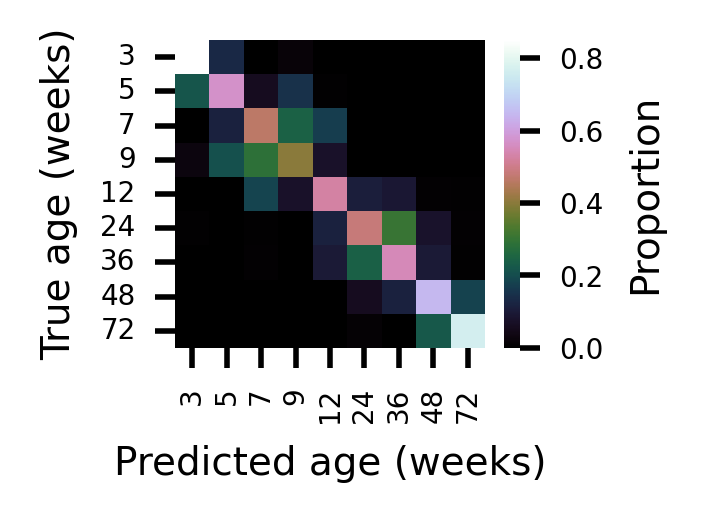

In [17]:
sort_labels = unique[[3, 4, 6, 8, 2, 5, 7, 0, 1]]
cm = confusion_matrix(ages, lr_preds, labels=sort_labels)

col = [3, 5, 7, 9, 12, 24, 9 * 4, 12 * 4, 18 * 4]
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=col, index=col)

fig = plt.figure(figsize=(1.25, 1))
ax = sns.heatmap(cm_df, annot=False, cmap='cubehelix', cbar_kws=dict(label='Proportion'), vmax=0.85, vmin=0)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)')
saver(fig, 'raw-pose-age-classification-confusion-mtx');

In [18]:
chance = 1 / len(np.unique(ages))
chance

0.1111111111111111

In [19]:
train_data = []
ages = []

for k, v in keep_lbls.items():
    ages.extend([k.split('_')[2]] * len(v))
    train_data.append(preds[k][np.sort(v.index)])
ages = np.array(ages)
train_data = np.concatenate(train_data, axis=0)

In [20]:
preds_out = cross_val_score(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    # cv=StratifiedKFold(5),
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=0),
)
preds_out

array([0.19876543, 0.19423868, 0.19135802, 0.21111111, 0.20740741,
       0.19917695, 0.21769547, 0.19753086, 0.20658436, 0.19135802,
       0.21316872, 0.2127572 , 0.19218107, 0.20082305, 0.18765432,
       0.20205761, 0.20205761, 0.20493827, 0.1909465 , 0.19958848])

In [21]:
lr_preds = cross_val_predict(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    cv=StratifiedKFold(5)
)

In [22]:
unique = np.unique(ages)
unique

array(['12months', '18months', '3months', '3wks', '5wks', '6months',
       '7wks', '9months', '9wks'], dtype='<U8')

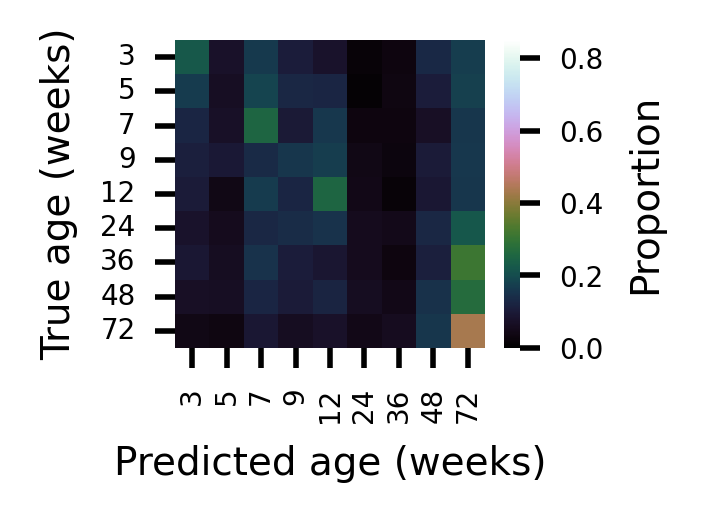

In [52]:
sort_labels = unique[[3, 4, 6, 8, 2, 5, 7, 0, 1]]
cm = confusion_matrix(ages, lr_preds, labels=sort_labels)

col = [3, 5, 7, 9, 12, 24, 9 * 4, 12 * 4, 18 * 4]
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=col, index=col)

fig = plt.figure(figsize=(1.25, 1))
ax = sns.heatmap(cm_df, annot=False, cmap='cubehelix', cbar_kws=dict(label='Proportion'), vmax=0.85, vmin=0)
ax.set(xlabel='Predicted age (weeks)', ylabel='True age (weeks)');
saver(fig, 'transformed-pose-age-classification-confusion-mtx');

In [24]:
outcomes = dict(
    Raw=out,
    Transformed=preds_out,
)

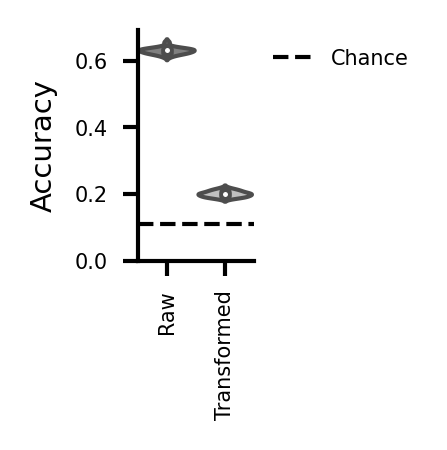

In [51]:
fig = plt.figure(figsize=(0.5, 1))
fig.dpi = 150
ax = sns.violinplot(data=pd.DataFrame(outcomes), palette=['gray', 'silver'], linewidth=1, saturation=1, width=0.95)
# ax = sns.pointplot(data=pd.DataFrame(outcomes), palette=['gray', 'silver'], errorbar=('sd', 2), scale=0.5)
plt.axhline(chance, color='k', ls='--', label='Chance')
ax.set(ylim=(0, None), ylabel='Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()
saver(fig, 'age-decoder-from-pose');

## Compare size distributions before and after applying model

In [26]:
from toolz import groupby, compose
from toolz.curried import pluck

In [27]:
selection = {}
for k, v in keep_lbls.items():
    selection[k] = data[k][np.sort(v.index)]
selection = groupby(lambda k: k[0].split('_')[2], selection.items())
selection = valmap(compose(np.concatenate, list, pluck(1)), selection)

pred_selection = {}
for k, v in keep_lbls.items():
    pred_selection[k] = preds[k][np.sort(v.index)]
pred_selection = groupby(lambda k: k[0].split('_')[2], pred_selection.items())
pred_selection = valmap(compose(np.concatenate, list, pluck(1)), pred_selection)

In [28]:
area = valmap(lambda v: np.mean((v > 10).sum(axis=(1, 2))), selection)
pred_area = valmap(lambda v: np.mean((v > 10).sum(axis=(1, 2))), pred_selection)
areas = pd.DataFrame(dict(
    Raw=area.values(),
    Transformed=pred_area.values(),
), index=area.keys())

In [29]:
areas = areas.sort_values(by='Raw')

In [30]:
areas

,Raw,Transformed
3wks,360.954815,617.668889
5wks,450.173333,616.956296
9wks,552.237778,635.248889
7wks,575.982222,639.008889
3months,704.726667,669.022963
9months,757.939259,636.242963
6months,849.277037,653.471111
12months,943.092593,644.834074
18months,1099.174815,648.991111


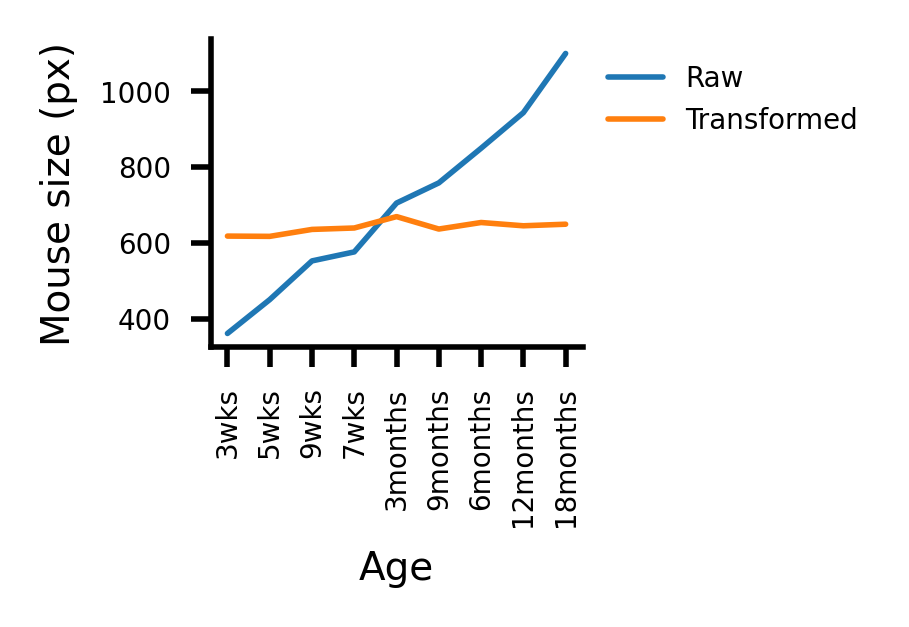

In [31]:
ax = areas.sort_values(by='Raw').plot(figsize=(1.2, 1))
# fig.dpi = 100
ax.set(ylabel='Mouse size (px)', xlabel='Age', xticks=range(len(areas)))
ax.set_xticklabels(labels=areas.index, rotation=90)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()
fig = plt.gcf()
saver(fig, 'mouse-size-after-model');

In [32]:
areas.std()

Raw            239.445179
Transformed     16.564801
dtype: float64

In [40]:
selection = {}
for k, v in keep_lbls.items():
    selection[k] = data[k][np.sort(v.index)]

pred_selection = {}
for k, v in keep_lbls.items():
    pred_selection[k] = preds[k][np.sort(v.index)]

In [41]:
area = valmap(lambda v: np.mean((v > 10).sum(axis=(1, 2))), selection)
pred_area = valmap(lambda v: np.mean((v > 10).sum(axis=(1, 2))), pred_selection)
areas = pd.DataFrame(dict(
    Raw=area.values(),
    Transformed=pred_area.values(),
), index=area.keys())

In [43]:
areas.std()

Raw            232.687025
Transformed     16.940546
dtype: float64

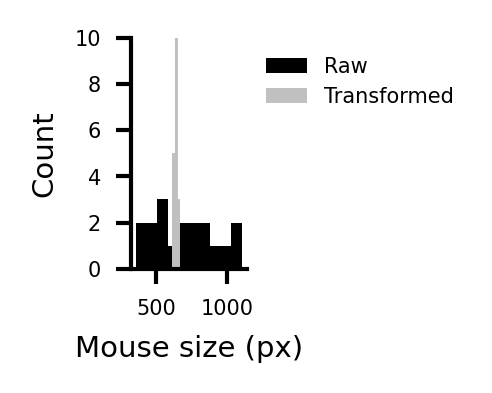

In [50]:
fig = plt.figure(figsize=(0.5, 1))
fig.dpi = 150
ax = sns.histplot(areas['Raw'], label='Raw', bins=10, element='step', lw=0, color='k', alpha=1)
ax = sns.histplot(areas['Transformed'], label='Transformed', bins=3, element='step', lw=0, color='silver', alpha=1)
ax.set(xlabel='Mouse size (px)', ylim=(0, 10))
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()
saver(fig, 'mouse-size-histogram');

## Preserved pose dynamics

In [4]:
def zscore(data):
    return (data - data.mean()) / data.std()

In [5]:
syll_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')

In [6]:
syll_df.head()

,experiment,file,syllables,date,uuid,age,session_name,subject_name,timestamps,area_mm,...,height_ave_mm,length_mm,velocity_2d_mm,velocity_3d_mm,width_mm,angle,velocity_theta,recon_width,recon_length,recon_height
0,ontogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,56,2021-04-29 10:49:26,0503a98f-a591-4493-af78-c10cc7e6369a,18months,ontogeny_cohorts_18months_29042021,m07_c02_b03_s01,0.000000,2538.265869,...,24.263941,83.603668,0.0,0.0,63.296543,2.193634,0.0,33.733256,60.725738,29.278524
1,ontogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,56,2021-04-29 10:49:26,0503a98f-a591-4493-af78-c10cc7e6369a,18months,ontogeny_cohorts_18months_29042021,m07_c02_b03_s01,0.033333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ontogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,56,2021-04-29 10:49:26,0503a98f-a591-4493-af78-c10cc7e6369a,18months,ontogeny_cohorts_18months_29042021,m07_c02_b03_s01,0.066667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ontogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,56,2021-04-29 10:49:26,0503a98f-a591-4493-af78-c10cc7e6369a,18months,ontogeny_cohorts_18months_29042021,m07_c02_b03_s01,0.100000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ontogeny_males,/n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...,56,2021-04-29 10:49:26,0503a98f-a591-4493-af78-c10cc7e6369a,18months,ontogeny_cohorts_18months_29042021,m07_c02_b03_s01,0.133333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
width_cols = ["width_mm", "recon_width"]
length_cols = ["length_mm", "recon_length"]
height_cols = ["height_ave_mm", "recon_height"]

age_map = {
    "12months": 12 * 4,
    "18months": 18 * 4,
    "3wks": 3,
    "5wks": 5,
    "9wks": 9,
    "7wks": 7,
    "22months": 22 * 4,
    "3months": 3 * 4,
    "6months": 6 * 4,
    "9months": 9 * 4,
}

In [8]:
preserve_df = []
for age, age_df in syll_df.groupby('age'):
    for uuid, uuid_df in age_df.groupby('uuid'):
        smooth_cols = zscore(uuid_df[width_cols + length_cols + height_cols].rolling(5, center=True).mean())
        corrs = np.diag(smooth_cols.corr(), 1)[::2]
        preserve_df.append(dict(
            age=age_map[age],
            uuid=uuid,
            avg_corr=np.mean(corrs),
            **dict(zip(('width', 'length', 'height'), corrs)),
        ))
preserve_df = pd.DataFrame(preserve_df)

In [9]:
preserve_df

,age,uuid,avg_corr,width,length,height
0,48,14d5ccc2-3375-4ba9-b874-5fccde870982,0.838963,0.713328,0.862055,0.941506
1,48,1900e596-c4a5-44ff-ba88-ce3a19b030cd,0.809146,0.637309,0.895541,0.894589
2,48,1a3792eb-abcd-4886-add4-9c6535c843a7,0.820860,0.705501,0.857671,0.899408
3,48,3abf3f43-233d-4370-8110-2b81873de5a7,0.802834,0.668030,0.875626,0.864847
4,48,4223f9ff-a26b-4605-869e-2ee7134f0d22,0.843447,0.707353,0.903244,0.919744
...,...,...,...,...,...,...
208,9,e1862cc7-e23c-4a8b-b134-66b7abee3c1a,0.899287,0.838621,0.909251,0.949988
209,9,e91beae5-468b-4c0b-940d-7663a02a68d0,0.808488,0.723164,0.806166,0.896134
210,9,ec7d35f8-4796-42ee-aa72-c381b95263b4,0.847176,0.740838,0.887215,0.913476
211,9,eca0cb8f-cae1-4a12-9de8-48e14723c7e8,0.905610,0.840387,0.913277,0.963165


In [10]:
best_examples = preserve_df.groupby('age').apply(lambda x: x.loc[x['avg_corr'].idxmax()]).reset_index(drop=True)

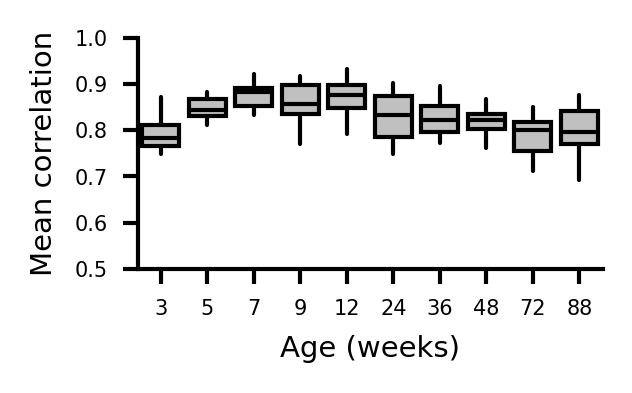

In [131]:
fig = plt.figure(figsize=(2, 1), dpi=150)
ax = sns.boxplot(
    data=preserve_df,
    x="age",
    y="avg_corr",
    showcaps=False,
    color="silver",
    saturation=1,
    boxprops=dict(ec="k"),
    medianprops=dict(c="k"),
    whiskerprops=dict(color="k"),
    showfliers=False
)
ax.set(ylim=(0.5, 1), ylabel='Mean correlation', xlabel='Age (weeks)')
sns.despine()
saver(fig, 'correlation-vs-age-boxplot');

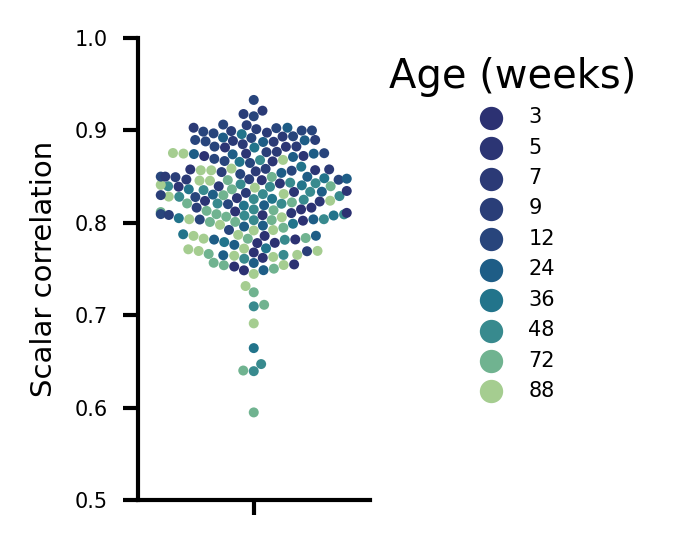

In [23]:
fig = plt.figure(figsize=(1, 2), dpi=150)
ax = sns.swarmplot(
    data=preserve_df,
    y="avg_corr",
    hue="age",
    palette="crest_r",
    size=2.4,
    legend='full',
    norm="log",
    # saturation=1,
)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left', title="Age (weeks)")
ax.set(ylim=(0.5, 1), ylabel='Scalar correlation')
sns.despine()
# saver(fig, 'correlation-vs-age-swarmplot');

In [132]:
best_examples

,age,uuid,avg_corr,width,length,height
0,3,509f6963-4a1c-43af-9ba4-909c7304cc39,0.872222,0.808744,0.890505,0.917416
1,5,9971bd0c-b48e-41b0-9611-fffc2caede9c,0.882264,0.819882,0.880835,0.946075
2,7,177de7e9-4af1-4fc3-bab1-abe4eb682aa3,0.921323,0.867671,0.916324,0.979972
3,9,2e94b0eb-59fd-41b4-9af0-74f665e93c46,0.917740,0.859790,0.928300,0.965129
4,12,4fc1b9c5-5524-49c3-86b3-b3f8cb1d5a1f,0.932964,0.883347,0.934722,0.980822
5,24,08561952-5528-421c-bb1a-3f8ed3ec9790,0.902889,0.833268,0.908564,0.966835
6,36,e22cc30f-d65a-4d23-9581-18b821030eae,0.895958,0.835801,0.923318,0.928753
7,48,d734c8b9-2ab6-464d-95cf-3dbddcc70880,0.867846,0.809035,0.898670,0.895832
8,72,f436246c-372b-4ce9-9e82-7ba5cefc391c,0.849624,0.722631,0.889674,0.936567
9,88,d7931c99-dd98-4300-8729-08b3be5ad555,0.875534,0.761466,0.907401,0.957736


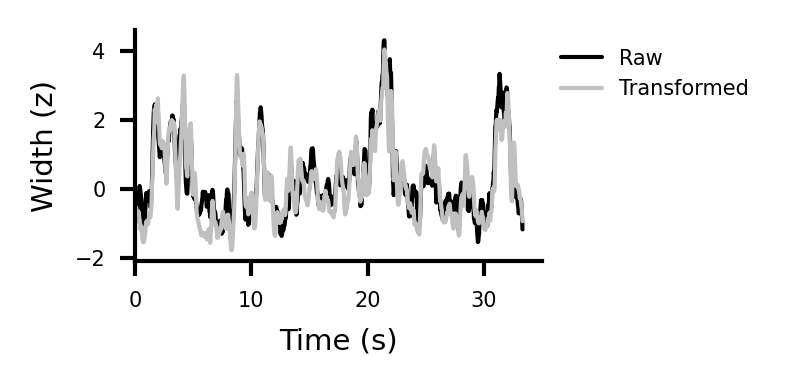

In [133]:
example = syll_df[syll_df['uuid'] == best_examples.query('age == 3')['uuid'].iloc[0]]
smooth_cols = zscore(example[width_cols + length_cols + height_cols].rolling(5, center=True).mean())

# 3wk width
plt_sample = smooth_cols.iloc[3500:4500]

fig = plt.figure(figsize=(1.75, 1), dpi=150)
ax = fig.gca()
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[0]], label='Raw', color='k')
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[1]], label='Transformed', color='silver')
ax.set(ylabel='Width (z)', xlabel='Time (s)', xlim=(0, None))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
sns.despine()
saver(fig, '3wk-width-timeseries');

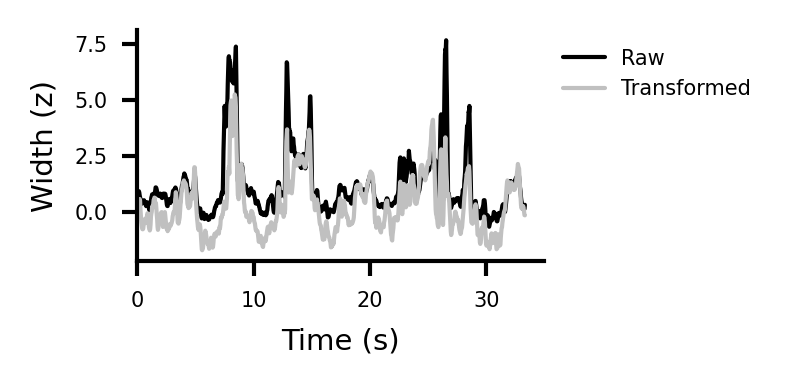

In [134]:
example = syll_df[syll_df['uuid'] == best_examples.query('age == 72')['uuid'].iloc[0]].reset_index(drop=True)
smooth_cols = zscore(example[width_cols + length_cols + height_cols].rolling(5, center=True).mean())

# 18 month width
plt_sample = smooth_cols.iloc[2000:3000]

fig = plt.figure(figsize=(1.75, 1), dpi=150)
ax = fig.gca()
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[0]], label='Raw', color='k')
ax.plot(np.arange(len(plt_sample)) / 30, plt_sample[width_cols[1]], label='Transformed', color='silver')
ax.set(ylabel='Width (z)', xlabel='Time (s)', xlim=(0, None))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
sns.despine()
saver(fig, '18mo-width-timeseries');